<a href="https://colab.research.google.com/github/bootstrap666/compressiveSensingPianoBasis/blob/main/CSaudio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Encontrei essa página na Universidade de Columbia que tem um arquivo de áudio para teste

In [1]:
!python -m pip install git+https://github.com/carnotresearch/cr-sparse.git
!wget https://www.ee.columbia.edu/~dpwe/sounds/music/africa-toto.wav

  Cloning https://github.com/carnotresearch/cr-sparse.git to /tmp/pip-req-build-ambov1r4
  Running command git clone -q https://github.com/carnotresearch/cr-sparse.git /tmp/pip-req-build-ambov1r4
--2021-10-29 13:53:49--  https://www.ee.columbia.edu/~dpwe/sounds/music/africa-toto.wav
Resolving www.ee.columbia.edu (www.ee.columbia.edu)... 104.18.19.34, 104.18.18.34, 2606:4700::6812:1322, ...
Connecting to www.ee.columbia.edu (www.ee.columbia.edu)|104.18.19.34|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13140922 (13M) [audio/x-wav]
Saving to: ‘africa-toto.wav.1’

africa-toto.wav.1   100%[===================>]  12.53M  3.05MB/s    in 4.0s    

2021-10-29 13:53:53 (3.12 MB/s) - ‘africa-toto.wav.1’ saved [13140922/13140922]



In [2]:
import numpy as np
from scipy import sparse,fft
import soundfile as sfile
from IPython.display import Audio
import time
from scipy import optimize
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import cmath
import math as m
import jax.numpy as jnp
import matplotlib.pyplot as plt
import cr.sparse as crs
from cr.sparse import lop
from cr.sparse import metrics
from cr.sparse.dsp import time_values

Fazendo a carga de uma pequena parte do arquivo parametrizada pelos parâmetros start (amostra inicial) e stop (amostra final). O arquivo foi amostrado a 22050 amostras/s

In [3]:
#toto, fs = sfile.read('africa-toto.wav',start=8000, stop=16096 )
starttoto = 16000
lengthtoto = 1024
toto, fs = sfile.read('africa-toto.wav',start=starttoto, stop=starttoto+lengthtoto )
Audio(toto,rate=fs)

Visualização da forma de onda do áudio

1024


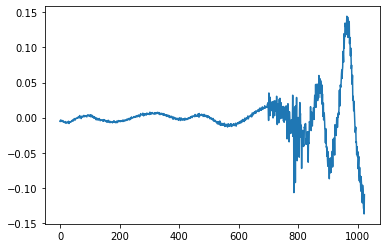

In [4]:
plt.plot(toto)
print(toto.size)

Visualização do espectro. Nota-se que a energia do sinal está concentrada fortemente em frequências baixas, indicando que o sinal pode ser esparso no domínio da FFT

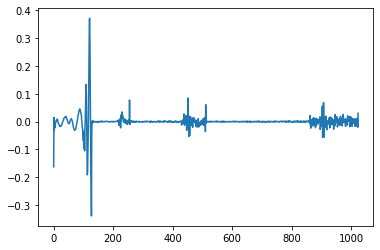

In [6]:
#DWT_op = lop.dwt(len(toto), wavelet='dmey', level=5)
DWT_op = lop.dwt(len(toto), wavelet='dmey', level=3)

alpha = DWT_op.times(toto)
plt.plot(alpha)

Para teste, criando uma versão do sinal de entrada com somente maxfreq/2 frequências, tirando a fft inversa e verificando tanto auditivamente quanto pela forma de onda se o sinal parece ser compressível no domínio da fft com maxfreq frequências. O teste auditivo indica que o som fica bastante abafado mas ainda reconhecível. A forma de onda mantém boa parte da informação, exceto entre as amostras 5000 até 7000 em que existe uma diferença mais significativa

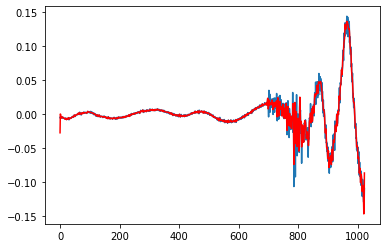

In [7]:
maxfreq = 512

freqs = np.arange(maxfreq)

#freqs = genfreqs(maxfreq,len(toto))

#testfreq = np.zeros(len(toto), dtype=complex)
#totofreq = fft.fft(toto)
#testfreq[freqs] = totofreq[freqs]

#test = fft.ifft(testfreq)

alpha2 = alpha.at[maxfreq:].set(0)
test = DWT_op.trans(alpha2)

plt.plot(toto)
plt.plot(test,'r')
Audio(test,rate=fs)

In [8]:
def CSpiano_ThetaMatrix(inplen,freqs):
  #Theta = np.zeros((len(freqs),inplen),dtype=complex)
  Theta = np.zeros((len(freqs),inplen))
  #Psi = np.random.normal(loc=0.0, scale=1.0, size=(inplen,inplen))

#  Psi = gs(Psi)

  for i in range(inplen):
    measurementvector = np.random.normal(loc=0.0, scale=1.0, size=inplen)

    #mvfreq = fft.fft(measurementvector)
    mvfreq = DWT_op.times(measurementvector)
    for j in range(len(freqs)):
      #Theta[j,i] = mvfreq[freqs[j]]
      Theta[j,i] = mvfreq[j]
    #Psi [i,range(inplen)] = measurementvector
  return Theta#, Psi

Tentando rodar o algoritmo de otimização do Python 3

In [9]:
Theta = CSpiano_ThetaMatrix(len(toto),freqs)

y = Theta @ toto

In [10]:
def objective_fun(vec):
  return np.linalg.norm(vec,1)

In [11]:
def gradient_objective_fun(vec):
  return np.sign(vec)

In [14]:
recovered = np.zeros(len(toto))
#recovered = toto

constraint = optimize.LinearConstraint (Theta,y,y)

res = minimize(objective_fun, recovered, method='trust-constr', jac=gradient_objective_fun,
               constraints=[constraint],
               options={'verbose': 1})

/usr/local/lib/python3.7/dist-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


`xtol` termination condition is satisfied.
Number of iterations: 283, function evaluations: 333, CG iterations: 471, optimality: 1.31e+00, constraint violation: 1.22e-15, execution time: 3.7e+01 s.


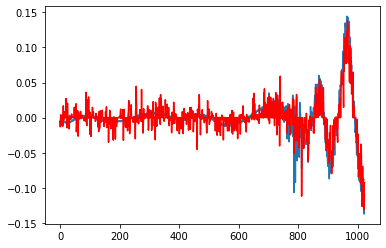

In [15]:
recovered = res.x

plt.plot(toto)
plt.plot(recovered,'r')
Audio(recovered,rate=fs)